### ЭТО ПРОДОЛЖЕНИЕ задачи на тему "Уйдет ли пользователь с курса или не уйдет?"

см файл ML data preprocessing 

или https://github.com/anthonypotekhin/studying/blob/main/ML_stepic_carpov/ML%20data%20preprocessing%20(stepic)%20.ipynb

#### переформулируем нашу задачу на язык машинного обучения. 

Наша цель как можно раньше предсказать, что пользователь уйдёт с курса "Анализ данных в R" и давайте для начала решим первую версию задачи. 

Для этого ответим на опрос - "можем ли мы, анализируя поведения пользователя за первые N дней, предсказать тот факт, что пользователь пройдёт курс до конца или дропнется и не наберёт нужное количество баллов?".

#### Подгрузим все ранее предобработанные данные:
делали это на этапе preprocessing

In [2]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# reading datasets
events_data = pd.read_csv('/Users/tony_builder/tony. Личное/IT/Mashine Learning/event_data_train.csv')
submissions_data = pd.read_csv('/Users/tony_builder/tony. Личное/IT/Mashine Learning/submissions_data_train.csv')

In [3]:
# adding new columns
events_data['date'] = pd.to_datetime(events_data.timestamp, unit='s')
events_data['day'] = events_data.date.dt.date

submissions_data['date'] = pd.to_datetime(submissions_data.timestamp, unit='s')
submissions_data['day'] = submissions_data.date.dt.date

# calculating for each user count correct submimit
users_scores = submissions_data.pivot_table(index='user_id',
                        columns='submission_status',
                        values='step_id',
                        aggfunc='count',
                        fill_value=0).reset_index()

users_data = events_data.groupby('user_id', as_index=False) \
    .agg({'timestamp': 'max'}).rename(columns={
    'timestamp': 'last_timestamp'
})

now = 1526772811
drop_out_treshold = 30 * 24 * 60 * 60 # пороговое значение
users_data['is_gone_user'] = (now - users_data.last_timestamp) > drop_out_treshold

users_data = users_data.merge(users_scores, on='user_id', how='outer')
users_data = users_data.fillna(0)

users_events_data = events_data.pivot_table(index='user_id',
                        columns='action',
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index()
users_data = users_data.merge(users_events_data, how='outer')

users_days = events_data.groupby('user_id').day.nunique()
users_days = events_data.groupby('user_id').day.nunique().to_frame().reset_index()
users_data = users_data.merge(users_days, how='outer')

users_data['passed_course'] = users_data.passed > 175

In [4]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False


еще раз убедимся, что никакие данные мы не потеряли

In [5]:
users_data.user_id.nunique()

19234

In [27]:
events_data.user_id.nunique()

19234

Итак, мы знаем:

- его статус на текущий момент (правда ли, что он закончил курс успешно / дропнулся), + сколько он сделал попыток,
- когда его последний раз видели на курсе.

попробуем, анализируя поведение пользователя за его первые несколько дней, после которых он начал курс, предсказать - правда ли, что он успешно закончит курсу или дропнется с него

Для начала можно предположить, что мы можем использовать, скажем, первые 2-3 дня. Вообще, есл бы мы решали эту задачу по-настоящему - это как раз тот пример. когда у нас нет готового правильного ответа на вопрос "сколько первых дней нам нужно, чтобы предсказать уйдёт пользователь с курса или нет?". 

        Поэтому можно попробовать разные пороги, нащупать какой-то оптимальный баланс времени и качества. Понятное дело, что если мы будем использовать первые две недели, то мы слишком поздно будем реагировать. Если мы будем пытаться предсказывать поведение пользователя за первые два часа с момента его начала работы с курсом - это, конечно, здорово, но возможно мы потеряем в точности

Поэтому нужно экспериментировать и давайте начнём, например, с 3-х дней. 

Для начала можно в принципе проверить насколько это адекватно, потому что у нас есть данные про то сколько уникальных дней пользователь потратил на прохождение курса - колонка day. Можно посчитать медиану, предварительно отобрав только те наблюдения, у которых passed_course = True

In [7]:
users_data[users_data.passed_course].day.median()

# здесь мы передаем значение фильтра в качестве имени столбца - потому что фильтрация по нему УЖЕ выведет булево значение, 
# а значит позволит взять ТОЛЬКО значения для которых True

# ну и для отобранных значений мы берем столбец "день" и считаем медиану 
# (серединное значение числа дней, которое пользователь тратит на завершение курса)

21.0

Построим гистограмму распределения по числу дней, которое нужно пользователю, чтобы закончить курс:

<AxesSubplot: >

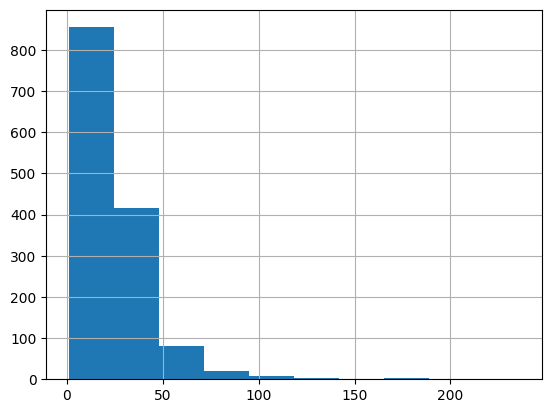

In [8]:
users_data[users_data.passed_course].day.hist()

Кстати, это тоже интересное наблюдение - большинство метрик, как-то характеризующих взаимодействие пользователя с продуктом, очень часто распределены не нормально. Скажем, процент лайков, репостов в соцсетях, количество дней, затраченных пользователями на прохождение курса, число решённых задач и т.д. Скорее всего это будет ненормальное распределение (готовьтесь к этому). 

Такие классические симметричные распределения в реальной практике на самом деле попадаются довольно редко.

Мы видим, что медиана 21, т.е. половина пользователей решает более 21 дня, поэтому 3 дня кажется адекватным порогом. Попробуем предсказать

##### первая задача: отобрать те наблюдения, которые мы будем использовать для обучения events_data, т.е. события, происходящие с пользователем в течение его **первых трёх дней** из общего датафрейма.

Сейчас здесь для каждого пользователя лежит вся его информация про все его действия на протяжении всей истории, доступной нам в этой выгрузке. Нам бы нужно для каждого юзера отобрать только его события, укладывающиеся в диапазон от его первого события **плюс 3 дня.**

Как же это сделать?

Отберём данные о первых активных действиях пользователя на курсе:

In [9]:
user_min_time = events_data.groupby('user_id', as_index=False) \
    .agg({'timestamp': 'min'}) \
    .rename({'timestamp': 'min_timestamp'}, axis=1)

In [13]:
user_min_time       # стартовая позиция каждого пользователя

,user_id,min_timestamp
0,1,1472827464
1,2,1514383364
2,3,1434358476
3,5,1466156809
4,7,1521634660
...,...,...
19229,26790,1451484016
19230,26793,1510225031
19231,26794,1495287049
19232,26797,1508425316


Добавляем эту информацию в наш подготовленный датасэт: (имеем столбец с первым вхождением на сайт)

In [14]:
users_data = users_data.merge(user_min_time, how='outer')

users_data

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course,min_timestamp
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False,1472827464
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False,1514383364
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False,1434358476
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False,1466156809
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False,1521634660
...,...,...,...,...,...,...,...,...,...,...,...,...
19229,26790,1517495987,True,1.0,0.0,8,8,1,9,4,False,1451484016
19230,26793,1510225034,True,0.0,0.0,1,0,1,1,1,False,1510225031
19231,26794,1512035039,True,33.0,9.0,69,69,34,180,9,False,1495287049
19232,26797,1509995096,True,2.0,0.0,10,10,2,13,2,False,1508425316


Теперь смотрите, довольно необычная задача и такую фильтрацию мы ещё не делали. 

Нам теперь нужно для данных, хранящихся в ***events_data***, **отобрать только наблюдения, проходящие по некоторому условию**, а именно - 
        
        у нас для каждого юзера есть некоторое его окно, в которое мы можем уместить нужные нам наблюдения, и их то и нужно отобрать.

Задача довольно интересная, потому что это такая нетривиальная фильтрация и решить её можно несколькими способами.

#### 1 способ (неправильный)
потому что очень длинный по времени цикла

In [ ]:
event_data_train = pd.DataFrame() # сюда сложим уже отобранные данные

for user_id in users_data.user_id:
    min_user_time = users_data[users_data.user_id == user_id].min_timestamp.item()
    time_treshold = min_user_time + 3 * 24 * 60 * 60 # minimal timestamp + 3 days in seconds
    
    user_events_data = events_data[(events_data.user_id == user_id) & (events_data.timestamp < time_treshold)]

    event_data_train.append(user_events_data)
    
    break

# то есть в цикле бежим по каждому пользователю
# для которого отбираем минимальное значение времени (первое вхождение) 
# и прибавляем к этому времени плюс трое (3) суток - как планировали

# а теперь собираем промежуточный датасэт, в котором хранится информация по каждому юзеру 
# и событиям + 3 дня (у каждого пользователя это будет свой набор событий) 


================================================= Важно ====================================================

Выход break из цикла после первой итерации - хорошая привычка. Когда вы разрабатываете какой-то сложный цикл - не нужно ждать, пока он весь отработает, есть смысл проверить корректность работы первой итерации. И только потом прогружать его полностью.

================================================================================================================

#### 2 способ (правильный)
сделать все по принципу pandas way - Одной командой, одной маской сделать event_data_train, указав, что это event_data с некоторым условием:

То есть это такой путь, при котором наша задача решится одним запросом на фильтр.


In [28]:
event_data_train = events_data[]

SyntaxError: invalid syntax (3124513090.py, line 1)

опять же, решение задачи такого рода фильтрации может быть выполнено несколькими способами, используем один: 

Мы не можем сделать фильтрацию только по user_id, нам нужно сложное комбинированное условие по user_id и timestamp. Для каждого user_id границы timestamp разные и как к этому подойти - непонятно.

1) создадим колонку в events_data с данными по типу "пользователь_временная метка": 

In [29]:
events_data['user_time'] = events_data.user_id.map(str) + '_' + events_data.timestamp.map(str)

events_data

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_treshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
...,...,...,...,...,...,...,...,...
3480698,32814,1526762783,discovered,943,2018-05-19 20:46:23,2018-05-19,943_1526762783,943_1527021864
3480699,32814,1526762783,passed,943,2018-05-19 20:46:23,2018-05-19,943_1526762783,943_1527021864
3480700,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19,5198_1526772750,5198_1527031950
3480701,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19,5198_1526772750,5198_1527031950


2) создадим константу, в которой сохраним количество секунд в **трех сутках**

In [16]:
learning_time_treshold = 3 * 24 * 60 * 60
learning_time_treshold

259200

3) создадим серию (колонку), в которой будем держать информацию о пользователе и его временной метке через трое суток

то есть метка будет выглядеть так: "пользователь_**временная метка от первого вхождения плюс трое суток**"

In [18]:
user_learning_time_treshold = user_min_time.user_id.map(str) + '_' + (user_min_time.min_timestamp + 
                                                                      learning_time_treshold).map(str)

user_learning_time_treshold.head()

0    1_1473086664
1    2_1514642564
2    3_1434617676
3    5_1466416009
4    7_1521893860
dtype: object

4) вставим этот столбец в таблчику с информацией о первом вхождении:

In [19]:
user_min_time['user_learning_time_treshold'] = user_learning_time_treshold

user_min_time       # здесь информация о первом вхождении и о пороговом значении времени через трое суток от первого вхождения

,user_id,min_timestamp,user_learning_time_treshold
0,1,1472827464,1_1473086664
1,2,1514383364,2_1514642564
2,3,1434358476,3_1434617676
3,5,1466156809,5_1466416009
4,7,1521634660,7_1521893860
...,...,...,...
19229,26790,1451484016,26790_1451743216
19230,26793,1510225031,26793_1510484231
19231,26794,1495287049,26794_1495546249
19232,26797,1508425316,26797_1508684516


5) вошьем данные по пользовательскому времени в исходный датасэт

In [23]:
events_data = events_data.merge(user_min_time[['user_id', 'user_learning_time_treshold']], how='outer')

events_data

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_treshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
...,...,...,...,...,...,...,...,...
3480698,32814,1526762783,discovered,943,2018-05-19 20:46:23,2018-05-19,943_1526762783,943_1527021864
3480699,32814,1526762783,passed,943,2018-05-19 20:46:23,2018-05-19,943_1526762783,943_1527021864
3480700,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19,5198_1526772750,5198_1527031950
3480701,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19,5198_1526772750,5198_1527031950


6) теперь фильтруем всю нашу таблицу, проверяя, чтобы все значения времени пользователя были меньше, чем пороговое

In [31]:
events_data_train = events_data[events_data.user_time <= events_data.user_learning_time_treshold]

events_data_train       # сохраняем эту информацию в новый датасэт

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_treshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
...,...,...,...,...,...,...,...,...
3480698,32814,1526762783,discovered,943,2018-05-19 20:46:23,2018-05-19,943_1526762783,943_1527021864
3480699,32814,1526762783,passed,943,2018-05-19 20:46:23,2018-05-19,943_1526762783,943_1527021864
3480700,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19,5198_1526772750,5198_1527031950
3480701,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19,5198_1526772750,5198_1527031950


кстати, тут ребята быстрее справились с фильтрацией: https://stepik.org/lesson/223834/step/6?unit=196653

### Задача: найти уникальный степ, который стал камнем преткновения для БОЛЬШИНСТВА пользователей

1) возьмем датасэт, который знает, насколько пользователь успешно решал задачи (проходил степы)

In [78]:
submissions_data

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15
...,...,...,...,...,...,...
509099,120745,1501946959,wrong,2615,2017-08-05 15:29:19,2017-08-05
509100,120745,1503059927,correct,13177,2017-08-18 12:38:47,2017-08-18
509101,120745,1506348153,wrong,15253,2017-09-25 14:02:33,2017-09-25
509102,120745,1523035316,wrong,1424,2018-04-06 17:21:56,2018-04-06


2) отфильтруем только те степы, которые решены неверно

3) сгруппируем их по пользователю и уроку(степу)

4) для сгруппированных колонок возьмем только те, у кого последняя временная метка - максимальная (это будет означать, что для каждого пользователя в каждом степе найдем время ПОСЛЕДНЕГО вхождения)

        иными словами, последняя зафиксированная попытка решить каждый из степов

5) построим гистограмму частот для каждого из уроков - какой из них встречается чаще всего в таблице с неверными решениями?

array([[<AxesSubplot: title={'center': 'step_id'}>]], dtype=object)

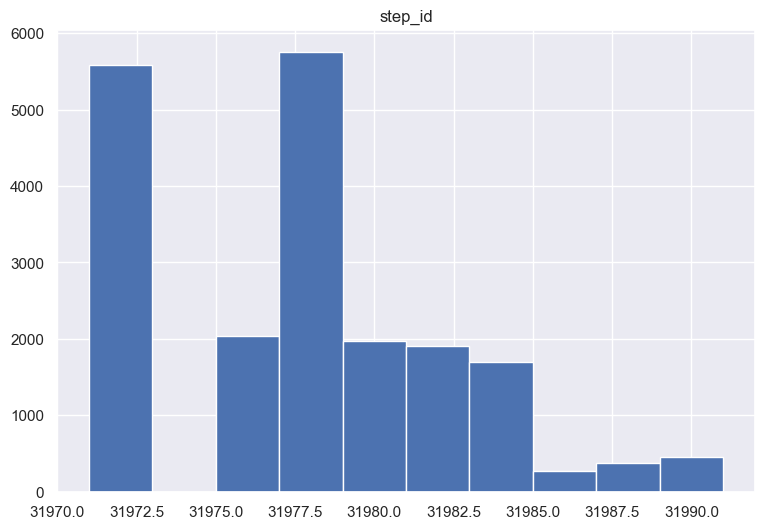

In [67]:
temp_data = submissions_data[submissions_data.submission_status=='wrong'].groupby(['user_id', 'step_id'], as_index=False)\
    .agg({'timestamp': 'max'})\
    .rename(columns={'timestamp':'last_try'})\

sns.set(rc={'figure.figsize': (9,6)}) 

temp_data[temp_data.step_id<32000].hist('step_id')

немного подкручивая масштаб гистограммы, увидим, что **наиболее часто встречаемое значение** лежит в диапазоне от 31977 до 31980 степа

найти точное значение поможет:
1) возьмем все степы из этого столбца
2) переведем его в список
3) удалим все повторяющиеся элементы из списка - воспользуемся переходом к типу множества
4) найдем максимальное значение, в качестве ключа используя функцию подсчета количества значений

In [77]:
spis = list(temp_data.step_id.values)
max(set(spis), key = spis.count)

31978

ну блин, или тупо возьмем МОДУ (mode) от всего столбца... (наиболее повторяющееся значение выборки)

In [79]:
temp_data.step_id.mode()

0    31978
Name: step_id, dtype: int64

### Продолжаем работать с данными:

убедимся, что ничего не сломали этой логикой и проверим максимальное число дней:

In [80]:
events_data_train.groupby('user_id').day.nunique().max()

4

Такое может быть, например, когда пользователь начал 1-го числа в середине дня, и трое суток в этом случае заденут и четвёртое число тоже. Но число больше 4-х мы уже никак не можем ожидать в наших данных, потому что это заложено в наш с вами порог

Проделаем все ранее выполненные операции и для датасэта submissions:

In [81]:
submissions_data['user_time'] = submissions_data.user_id.map(str) + '_' + submissions_data.timestamp.map(str)
submissions_data = submissions_data.merge(user_min_time[['user_id', 'user_learning_time_treshold']], how='outer')
submissions_data_train = submissions_data[submissions_data.user_time <= submissions_data.user_learning_time_treshold]
submissions_data_train.groupby('user_id').day.nunique().max()

4

заодно убедились, что все верно работает, максимальное число уникальных дней для каждого пользователя - 4 дня (то есть трое суток)

Соберём первый простенький вариант с фичами и целевой переменной и попробуем обучить хотя бы базовую модель, чтобы посмотреть, что у нас, в принципе, что-то получается и работает. Или это бесполезная задача и никакой точности прогнозирования за первые 3 дня добиться не удастся.

Заведём датафрейм X, который постепенно будем наполнять данными:
- для начала для каждого пользователя соберем уникально число дней, которое он провел на платформе (от 1 до 4)

In [159]:
X = submissions_data_train.groupby('user_id').day.nunique(). \
    to_frame().reset_index().rename(columns=({
        'day': 'days'
}))

X

,user_id,days
0,2,1
1,3,1
2,8,1
3,14,1
4,16,3
...,...,...
8908,26787,1
8909,26790,1
8910,26794,3
8911,26797,1


посчитаем, сколько степов пользователь попытался решить за первые три дня:

логика та же:
- группируем по юзеру
- по столбцу степов(уроков) берем функцию посчитать уникальные

In [160]:
steps_tried = submissions_data_train.groupby('user_id').step_id \
    .nunique().to_frame().reset_index().rename(columns={
        'step_id': 'steps_tried'
})

steps_tried

,user_id,steps_tried
0,2,2
1,3,4
2,8,11
3,14,1
4,16,23
...,...,...
8908,26787,3
8909,26790,1
8910,26794,27
8911,26797,2


наращиваем тренировочный датасэт Х

In [161]:
X = X.merge(steps_tried, on='user_id', how='outer')
X

,user_id,days,steps_tried
0,2,1,2
1,3,1,4
2,8,1,11
3,14,1,1
4,16,3,23
...,...,...,...
8908,26787,1,3
8909,26790,1,1
8910,26794,3,27
8911,26797,1,2


создадим вспомогательный датасэт, который наполним информацией о том, сколько правильных/неправильных степов решил пользователь, точнее сколько он дал верных ответов, а сколько неверных

In [162]:
temp_df = submissions_data_train.pivot_table(index='user_id',
                        columns='submission_status',
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index()

temp_df

submission_status,user_id,correct,wrong
0,2,2,0
1,3,4,4
2,8,9,21
3,14,0,1
4,16,23,27
...,...,...,...
8908,26787,3,0
8909,26790,1,0
8910,26794,31,9
8911,26797,2,0


какой-то монстр решил 76 задач за 4 дня

In [163]:
temp_df[temp_df.correct == max(temp_df.correct)]

submission_status,user_id,correct,wrong
6589,19805,76,9


наполняем тренировочный датасэт

In [164]:
X = X.merge(temp_df, on='user_id', how='outer')
X

,user_id,days,steps_tried,correct,wrong
0,2,1,2,2,0
1,3,1,4,4,4
2,8,1,11,9,21
3,14,1,1,0,1
4,16,3,23,23,27
...,...,...,...,...,...
8908,26787,1,3,3,0
8909,26790,1,1,1,0
8910,26794,3,27,31,9
8911,26797,1,2,2,0


упростим задачу нашей будущей модели: заведем столбец, показывающий долю правильных ответов ко все решениям

In [165]:
X['correct_ratio'] = X.correct/(X.wrong+ X.correct)
X

,user_id,days,steps_tried,correct,wrong,correct_ratio
0,2,1,2,2,0,1.000000
1,3,1,4,4,4,0.500000
2,8,1,11,9,21,0.300000
3,14,1,1,0,1,0.000000
4,16,3,23,23,27,0.460000
...,...,...,...,...,...,...
8908,26787,1,3,3,0,1.000000
8909,26790,1,1,1,0,1.000000
8910,26794,3,27,31,9,0.775000
8911,26797,1,2,2,0,1.000000


Посчитаем, сколько всего степов было посчитано суммарно (данные возьмем из датасэта events)
- возьмем pivot-table
- имена колонок возьмем из вида действий (открыл, посмотрел, прошел..)
- значения возьмем из колонки step_id
- скажем - посчитай
- сбросим индексы
- отберем только колонки Пользователь и Посмотрел (для объединения с тренировочным датасэтом)

In [166]:
temp_df = events_data_train.pivot_table(index='user_id',
                        columns='action',
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index()[['user_id', 'viewed']]

temp_df

action,user_id,viewed
0,1,1
1,2,9
2,3,20
3,5,1
4,7,1
...,...,...
19229,26790,6
19230,26793,1
19231,26794,134
19232,26797,10


во вспомогательном датасэте позиций больше, чем в тренировочном, поэтому мерджить с дополнительным аргументов how = outer:

In [167]:
X = X.merge(temp_df, how='outer')
X

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed
0,2,1.0,2.0,2.0,0.0,1.00,9
1,3,1.0,4.0,4.0,4.0,0.50,20
2,8,1.0,11.0,9.0,21.0,0.30,154
3,14,1.0,1.0,0.0,1.0,0.00,9
4,16,3.0,23.0,23.0,27.0,0.46,132
...,...,...,...,...,...,...,...
19229,26774,NaN,NaN,NaN,NaN,NaN,1
19230,26781,NaN,NaN,NaN,NaN,NaN,6
19231,26788,NaN,NaN,NaN,NaN,NaN,1
19232,26789,NaN,NaN,NaN,NaN,NaN,2


пустые позиции заполним нулями пока что

In [168]:
X = X.fillna(0)
X

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed
0,2,1.0,2.0,2.0,0.0,1.00,9
1,3,1.0,4.0,4.0,4.0,0.50,20
2,8,1.0,11.0,9.0,21.0,0.30,154
3,14,1.0,1.0,0.0,1.0,0.00,9
4,16,3.0,23.0,23.0,27.0,0.46,132
...,...,...,...,...,...,...,...
19229,26774,0.0,0.0,0.0,0.0,0.00,1
19230,26781,0.0,0.0,0.0,0.0,0.00,6
19231,26788,0.0,0.0,0.0,0.0,0.00,1
19232,26789,0.0,0.0,0.0,0.0,0.00,2


Теперь добавим в тренировочный датасэт информацию о том:
- покинул ли пользователь курс (более 30 дней не на платформе)
- закончил ли он курс (то есть решил более , чем на 170 баллов)

для этого используем user_data, подготовленный на тапе preprocessing и возьмем колонки is_gone and passed_course

In [169]:
users_data

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course,min_timestamp
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False,1472827464
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False,1514383364
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False,1434358476
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False,1466156809
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False,1521634660
...,...,...,...,...,...,...,...,...,...,...,...,...
19229,26790,1517495987,True,1.0,0.0,8,8,1,9,4,False,1451484016
19230,26793,1510225034,True,0.0,0.0,1,0,1,1,1,False,1510225031
19231,26794,1512035039,True,33.0,9.0,69,69,34,180,9,False,1495287049
19232,26797,1509995096,True,2.0,0.0,10,10,2,13,2,False,1508425316


In [170]:
X = X.merge(users_data[['is_gone_user', 'passed_course','user_id']], on='user_id', how='outer')
X

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed,is_gone_user,passed_course
0,2,1.0,2.0,2.0,0.0,1.00,9,True,False
1,3,1.0,4.0,4.0,4.0,0.50,20,True,False
2,8,1.0,11.0,9.0,21.0,0.30,154,True,False
3,14,1.0,1.0,0.0,1.0,0.00,9,True,False
4,16,3.0,23.0,23.0,27.0,0.46,132,True,True
...,...,...,...,...,...,...,...,...,...
19229,26774,0.0,0.0,0.0,0.0,0.00,1,True,False
19230,26781,0.0,0.0,0.0,0.0,0.00,6,True,True
19231,26788,0.0,0.0,0.0,0.0,0.00,1,True,False
19232,26789,0.0,0.0,0.0,0.0,0.00,2,True,False


Теперь оставим только тех, кто:
- либо закончил курс
- либо бросил его, недоучившись

Для такой фильтрации делаем:
1) сначала создадим условие:
- не бросил
- еще не закончил курс

2) А потом возьмем отрицание этого условия с помощью оператора ~
3) в итоге получим искомых пользователей

In [171]:
X = X[~ ((X.is_gone_user == False) & (X.passed_course == False))]   #создаем  одноврем отрицание двух условий 
X

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed,is_gone_user,passed_course
0,2,1.0,2.0,2.0,0.0,1.00,9,True,False
1,3,1.0,4.0,4.0,4.0,0.50,20,True,False
2,8,1.0,11.0,9.0,21.0,0.30,154,True,False
3,14,1.0,1.0,0.0,1.0,0.00,9,True,False
4,16,3.0,23.0,23.0,27.0,0.46,132,True,True
...,...,...,...,...,...,...,...,...,...
19229,26774,0.0,0.0,0.0,0.0,0.00,1,True,False
19230,26781,0.0,0.0,0.0,0.0,0.00,6,True,True
19231,26788,0.0,0.0,0.0,0.0,0.00,1,True,False
19232,26789,0.0,0.0,0.0,0.0,0.00,2,True,False


Теперь в X находятся пользователи, которые либо прошли курс, либо бросили его.

При этом, в колонке passed_course находятся те пользователи, которые дропнулись с курса - потому что мы фильтровали данные таким образом, что убирали тех, кто не уходил с курса и не закончил его еще. (разумеется под значением False)

но лучше в этом убедиться: 
- сгруппируем таблицу по значениям Завершил курс и Бросил курс
- посчитаем , как распределяются пользователи при такой группировке

In [172]:
X.groupby(['passed_course', 'is_gone_user']).user_id.count()

passed_course  is_gone_user
False          True            16590
True           False             136
               True             1254
Name: user_id, dtype: int64

для нашего тренировочного датасэта Х это означает:

- что если пользователь не завершил курс, то он ГАРАНТИВАРОВАННО дропнулся: для значения False в графе "закончил курс" есть только значение True в графе "пользователь ушел" - и это 16590 чел

- а если пользователь завершил курс, то два варианта: 
1) еще не прошло 30 дней с момента его последнего посещения - и это False в графе "ушел" - 136 чел
2) уже прошло больше 30 дней с момента его посл посещения - и это True в графе "ушел" - 1254 чел

        Таким образом выяснили, что в графе passed_course содержится искомая информация (дропнулся ли пользователь или нет) - именно это величину мы хотим предсказать - поэтому это Целевая переменная



- в переменной Х сохраним все, кроме столбцов про то, здесь ли еще пользователь или он уже ушел

- Заодно перенесем user_id в индексы, чтобы эти данные не мешали нам обучать модель, но сами данные мы не потеряем

In [173]:
X = X.set_index(X.user_id)
X = X.drop(['user_id'], axis =1)
X

,days,steps_tried,correct,wrong,correct_ratio,viewed,is_gone_user,passed_course
user_id,,,,,,,,
2,1.0,2.0,2.0,0.0,1.00,9,True,False
3,1.0,4.0,4.0,4.0,0.50,20,True,False
8,1.0,11.0,9.0,21.0,0.30,154,True,False
14,1.0,1.0,0.0,1.0,0.00,9,True,False
16,3.0,23.0,23.0,27.0,0.46,132,True,True
...,...,...,...,...,...,...,...,...
26774,0.0,0.0,0.0,0.0,0.00,1,True,False
26781,0.0,0.0,0.0,0.0,0.00,6,True,True
26788,0.0,0.0,0.0,0.0,0.00,1,True,False


в переменной y оставим только значения столбца passed_course

In [174]:
y = X.passed_course.map(int)        # плюс переведем все значения из булевых в целочисленные: 
                                    # заменим True/False на 1/0
y

user_id
2        0
3        0
8        0
14       0
16       1
        ..
26774    0
26781    1
26788    0
26789    0
26793    0
Name: passed_course, Length: 17980, dtype: int64

удалим все лишнее из тренировочного датасэта Х

In [175]:
X = X.drop(['is_gone_user', 'passed_course'], axis = 1)
X

,days,steps_tried,correct,wrong,correct_ratio,viewed
user_id,,,,,,
2,1.0,2.0,2.0,0.0,1.00,9
3,1.0,4.0,4.0,4.0,0.50,20
8,1.0,11.0,9.0,21.0,0.30,154
14,1.0,1.0,0.0,1.0,0.00,9
16,3.0,23.0,23.0,27.0,0.46,132
...,...,...,...,...,...,...
26774,0.0,0.0,0.0,0.0,0.00,1
26781,0.0,0.0,0.0,0.0,0.00,6
26788,0.0,0.0,0.0,0.0,0.00,1


        СОХРАНИМ НАШИ ПРЕДПОГОТОВЛЕННЫЕ ДАННЫЕ на всякий случай в отдельные файлы:

In [253]:
X.to_csv('X_data.csv')
y.to_csv('Y_data.csv')

### Потестим наши данные, пообучаем модели, посчитаем показатели

        1) Построим дерево решений, предскажем значения

In [131]:
from sklearn import tree
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split


In [128]:
from IPython.display import HTML
style = "<style>svg{width:30% !important;height:30% !important;}</style>"
HTML(style)

Разобьем тренировочный датасэт на значения для обучения модели в соотношении 30/70

In [178]:
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.3, random_state=42)

Подберем оптимальные параметры для модели

In [181]:
clf = tree.DecisionTreeClassifier() # передадим в переменную пустой классификатор

# передадим набор паарметров, которые нам предстоит подобрать (возьмем их ниже из возможных)
parametrs = {'criterion': ['gini', 'entropy'], 'max_depth': range(1,30)}  

# говорим подборщику, какие варианты параметров для модели нужно перебрать
grid_search_cv_clf = GridSearchCV(clf, parametrs, cv=5)     

grid_search_cv_clf.fit(X_train, y_train)        # обучаем модель на тренировочных данных

grid_search_cv_clf.best_params_             # вытаскиваем лучшие параметры

{'criterion': 'entropy', 'max_depth': 5}

сразу получаем наилучшую модель с выбранными параметрами:

In [182]:
best_clf = grid_search_cv_clf.best_estimator_
best_clf

DecisionTreeClassifier(criterion='entropy', max_depth=5)

Строим дерево решений:

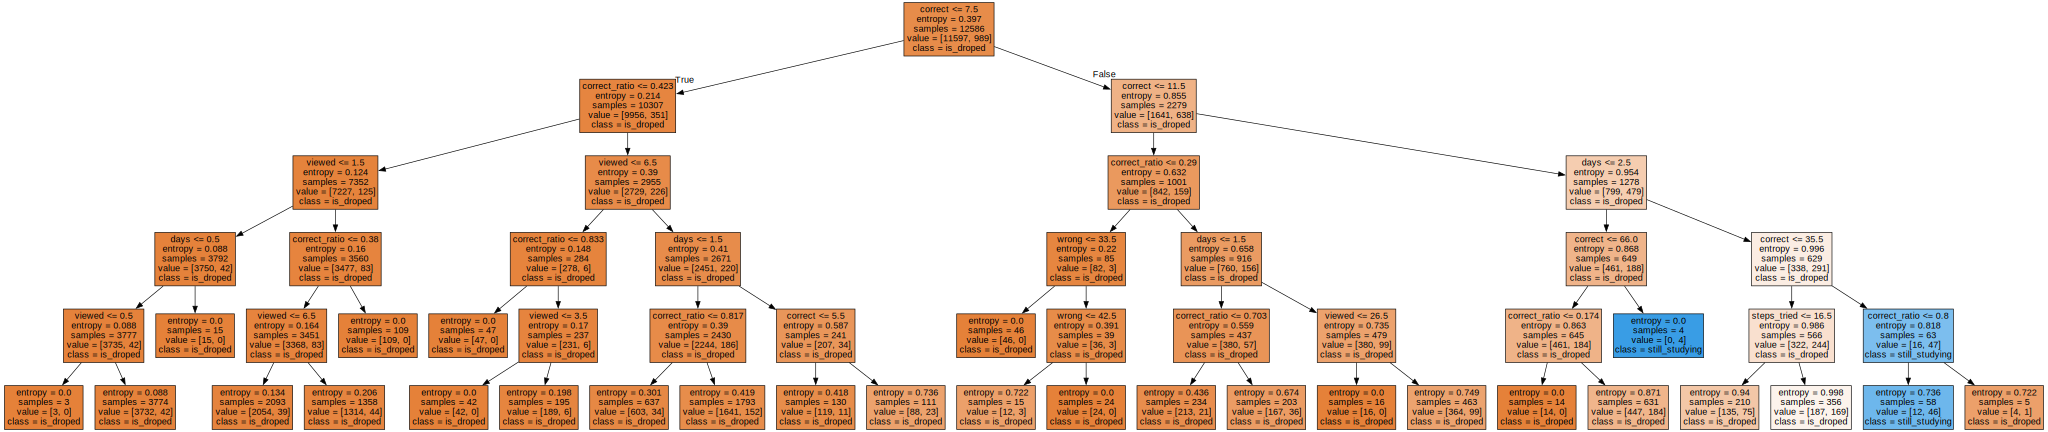

In [183]:
graph = Source(tree.export_graphviz(best_clf, out_file=None,
                                    feature_names=list(X_train),
                                    class_names=['is_droped', 'still_studying'],       # здесь добавили имена классам ([y=0, y=1])
                                    filled=True))
display(SVG(graph.pipe(format='svg')))

Предскажем значения, сравним их с фактическими:

In [186]:
y_predicted = best_clf.predict(X_test)

pred_temp_df = pd.DataFrame({'predicted_status' : y_predicted})

pred_temp_df

,predicted_status
0,0
1,0
2,0
3,0
4,0
...,...
5389,0
5390,0
5391,0
5392,0


создадим вспомогательный датасэт для тестовых значений перменных, включая тестовые значения ЦЕЛЕВОЙ переменной

In [188]:
test_df = X_test.copy()
test_df['true_status'] = y_test

test_df

,days,steps_tried,correct,wrong,correct_ratio,viewed,true_status
user_id,,,,,,,
19347,1.0,2.0,2.0,0.0,1.000000,10,0
8361,2.0,18.0,18.0,9.0,0.666667,55,0
14571,1.0,3.0,1.0,2.0,0.333333,14,0
14196,1.0,9.0,9.0,2.0,0.818182,26,0
15360,0.0,0.0,0.0,0.0,0.000000,1,0
...,...,...,...,...,...,...,...
10204,0.0,0.0,0.0,0.0,0.000000,2,0
9696,0.0,0.0,0.0,0.0,0.000000,1,0
15241,0.0,0.0,0.0,0.0,0.000000,1,0


По порядку:
- сбросим индексы для тестовых данных
- почистим их, заменив на целочисленные данные те колонки, к которым применимо
- присоединим сюда столбец с предсказанными значениями (для этого сбросили индексы)
- снова уберем столбец пользователей в индексы

In [215]:
result_df = test_df.reset_index()       # здесь сбросим индексы, чтобы можно было объединить с предсказанными значениями

# здесь в цикле заменим все значения на целые числа (избавимся от нулей после запятой)
for name in ['days', 'steps_tried', 'correct', 'wrong']:
    result_df[name] = result_df[name].map(int)


result_df['correct_ratio'] = result_df['correct_ratio'].round(2)        # округлить значение доли в столбце до 2 знака после запятой

result_df = result_df.join(pred_temp_df)                                # здесь цепляем столбец с предсказанными значениями

result_df['correct_prediction'] = result_df.true_status == result_df.predicted_status       # добавляем столбец, который покажет верно ли предсказание

# result_df = result_df.set_index('user_id')      # снова сделаем пользователей в качестве индексов - если захотим

result_df

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed,true_status,predicted_status,correct_prediction
0,19347,1,2,2,0,1.00,10,0,0,True
1,8361,2,18,18,9,0.67,55,0,0,True
2,14571,1,3,1,2,0.33,14,0,0,True
3,14196,1,9,9,2,0.82,26,0,0,True
4,15360,0,0,0,0,0.00,1,0,0,True
...,...,...,...,...,...,...,...,...,...,...
5389,10204,0,0,0,0,0.00,2,0,0,True
5390,9696,0,0,0,0,0.00,1,0,0,True
5391,15241,0,0,0,0,0.00,1,0,0,True
5392,20864,1,2,2,1,0.67,17,0,0,True


Теперь посчитаем сколько верных и неверных предсказаний сделал наш классификатор:
- сгруппируем данные по столбцу correct_prediction
- посчитаем пользователей

In [211]:
result_df.groupby('correct_prediction').user_id.count()

correct_prediction
False     386
True     5008
Name: user_id, dtype: int64

In [214]:
print(f'Точность модели составляет {round(5008/(386+5008)*100 , 1)}%')

Точность модели составляет 92.8%


Теперь посчитаем ВСЕ показатели:
- accuracy  (общая точность)
- precision (точность с учетом ложных срабатываний)
- recall    (полнота верных срабатываний)
- f1-score  (соотношение тоночти и полноты)

In [216]:
best_clf.score(X_test, y_test)      # точность модели

0.9284390063033

In [223]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score


print(f'- Accuracy  (общая точность) модели равна {round(accuracy_score(y_test, y_predicted), 3)}')
print(f'- Precision(точность с учетом ложных срабатываний) модели равна {round(precision_score(y_test, y_predicted), 3)}')
print(f'- Recall    (полнота верных срабатываний) модели равна {round(recall_score(y_test, y_predicted), 3)}')
print(f'- f1_score  (соотношение тоночти и полноты) модели равна {round(f1_score(y_test, y_predicted), 3)}')

- Accuracy  (общая точность) модели равна 0.928
- Precision(точность с учетом ложных срабатываний) модели равна 0.703
- Recall    (полнота верных срабатываний) модели равна 0.065
- f1_score  (соотношение тоночти и полноты) модели равна 0.119


#### Попробуем с Линейной регрессией

In [227]:
from sklearn.linear_model import LogisticRegression


model_lr = LogisticRegression()

model_lr.get_params()


{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [ ]:
parametrs = {'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
             'multi_class': ['auto', 'ovr', 'multinomial']}

# говорим подборщику, какие варианты параметров для модели нужно перебрать
grid_search_model = GridSearchCV(model_lr, parametrs, cv=5)     

grid_search_model.fit(X_train, y_train)        # обучаем модель на тренировочных данных

grid_search_model.best_params_  

In [231]:
best_linreg_model = grid_search_model.best_estimator_

best_linreg_model.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

Предскажем значения при помощи линейной регрессии

In [232]:
best_linreg_model.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0])

In [236]:
pred_temp_df_2 = pd.DataFrame({"lr_predicted_values": best_linreg_model.predict(X_test)})
pred_temp_df_2

,lr_predicted_values
0,0
1,0
2,0
3,0
4,0
...,...
5389,0
5390,0
5391,0
5392,0


Посчитаем точность модели линейной регрессии

In [233]:
best_linreg_model.score(X_test, y_test)

0.9263997033741194

Убедимся в этом вручную:

In [237]:
result2_df = test_df.reset_index()       # здесь сбросим индексы, чтобы можно было объединить с предсказанными значениями

# здесь в цикле заменим все значения на целые числа (избавимся от нулей после запятой)
for name in ['days', 'steps_tried', 'correct', 'wrong']:
    result2_df[name] = result2_df[name].map(int)


result2_df['correct_ratio'] = result2_df['correct_ratio'].round(2)        # округлить значение доли в столбце до 2 знака после запятой

result2_df = result2_df.join(pred_temp_df_2)                                # здесь цепляем столбец с предсказанными значениями

result2_df['correct_prediction'] = result2_df.true_status == result2_df.lr_predicted_values      # добавляем столбец, который покажет верно ли предсказание

# result_df = result_df.set_index('user_id')      # снова сделаем пользователей в качестве индексов - если захотим

result2_df

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed,true_status,lr_predicted_values,correct_prediction
0,19347,1,2,2,0,1.00,10,0,0,True
1,8361,2,18,18,9,0.67,55,0,0,True
2,14571,1,3,1,2,0.33,14,0,0,True
3,14196,1,9,9,2,0.82,26,0,0,True
4,15360,0,0,0,0,0.00,1,0,0,True
...,...,...,...,...,...,...,...,...,...,...
5389,10204,0,0,0,0,0.00,2,0,0,True
5390,9696,0,0,0,0,0.00,1,0,0,True
5391,15241,0,0,0,0,0.00,1,0,0,True
5392,20864,1,2,2,1,0.67,17,0,0,True


In [238]:
result2_df.groupby('correct_prediction').user_id.count()

correct_prediction
False     397
True     4997
Name: user_id, dtype: int64

Проверяем ручным счетом точность модели - она совпадает с рассчитанным

In [239]:
4997/(397+4997)

0.9263997033741194

Проверяем ресурсы, которые затрачены на это действие:

In [242]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score


print(f'- Accuracy  (общая точность) модели равна {round(accuracy_score(y_test, best_linreg_model.predict(X_test)), 3)}')

print(f'- Precision(точность с учетом ложных срабатываний) модели равна {round(precision_score(y_test, best_linreg_model.predict(X_test)), 3)}')

print(f'- Recall    (полнота верных срабатываний) модели равна {round(recall_score(y_test, best_linreg_model.predict(X_test)), 3)}')

print(f'- f1_score  (соотношение точности и полноты) модели равна {round(f1_score(y_test, best_linreg_model.predict(X_test)), 3)}')

- Accuracy  (общая точность) модели равна 0.926
- Precision(точность с учетом ложных срабатываний) модели равна 0.516
- Recall    (полнота верных срабатываний) модели равна 0.16
- f1_score  (соотношение точности и полноты) модели равна 0.244


        Точность с учетом ложных срабатываний получилась довольно низкой. 
        Это значит, что количество пользователей, продолжающих учиться, но определенных моделью линейной регрессии как **дропнувшиеся с курса**, довольно велико

### Попробуем с логистической регрессией, которая использует и кросс-валидацию

In [244]:
from sklearn.linear_model import LogisticRegressionCV


model_lr2 = LogisticRegressionCV()

model_lr2.get_params()

{'Cs': 10,
 'class_weight': None,
 'cv': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1.0,
 'l1_ratios': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'refit': True,
 'scoring': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0}

In [ ]:
parametrs = {'multi_class': ['auto', 'ovr', 'multinomial'],   
             'penalty': ['l2','l1','elasticnet'], 'cv': range(6)}

# говорим подборщику, какие варианты параметров для модели нужно перебрать
grid_search_model2 = GridSearchCV(model_lr2, parametrs)     

grid_search_model2.fit(X_train, y_train)        # запускаем подбор коэффициентов



In [247]:
grid_search_model2.best_params_  

{'cv': 3, 'multi_class': 'auto', 'penalty': 'l2'}

получаем наилучшую модель линейной регрессии

In [248]:
best_linreg_model_2 = grid_search_model2.best_estimator_
best_linreg_model_2

LogisticRegressionCV(cv=3)

Посчитаем все метрики для новой модели:

In [249]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

y_predicted = best_linreg_model_2.predict(X_test)

print(f'- Accuracy  (общая точность) модели равна {round(accuracy_score(y_test, y_predicted), 3)}')
print(f'- Precision(точность с учетом ложных срабатываний) модели равна {round(precision_score(y_test, y_predicted), 3)}')
print(f'- Recall    (полнота верных срабатываний) модели равна {round(recall_score(y_test, y_predicted), 3)}')
print(f'- f1_score  (соотношение тоночти и полноты) модели равна {round(f1_score(y_test, y_predicted), 3)}')

- Accuracy  (общая точность) модели равна 0.926
- Precision(точность с учетом ложных срабатываний) модели равна 0.512
- Recall    (полнота верных срабатываний) модели равна 0.16
- f1_score  (соотношение тоночти и полноты) модели равна 0.243


### Воспользуемся классификатором ближайших соседей
sclearn.neighbors

In [251]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score


knn = KNeighborsClassifier()

parameters = {'n_neighbors': range(15,25), 'leaf_size':range(1,7)}      # зададим параметры для перебора

grid_search_cv_clf = GridSearchCV(knn,parameters,cv=4,n_jobs=-1)

grid_search_cv_clf.fit(X_train,y_train)

neibors_model = grid_search_cv_clf.best_estimator_

# выведем лучшие параметры для модели, посчитаем среднее значение точности модели при кросс-валидации
print(grid_search_cv_clf.best_params_, cross_val_score(neibors_model,X_train,y_train,cv=4).mean())

{'leaf_size': 1, 'n_neighbors': 18} 0.921976797648433


Предскажем данные с помощью этой модели и посчитаем метрики:

In [252]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

y_predicted = neibors_model.predict(X_test)

print(f'- Accuracy  (общая точность) модели равна {round(accuracy_score(y_test, y_predicted), 3)}')
print(f'- Precision(точность с учетом ложных срабатываний) модели равна {round(precision_score(y_test, y_predicted), 3)}')
print(f'- Recall    (полнота верных срабатываний) модели равна {round(recall_score(y_test, y_predicted), 3)}')
print(f'- f1_score  (соотношение тоночти и полноты) модели равна {round(f1_score(y_test, y_predicted), 3)}')

- Accuracy  (общая точность) модели равна 0.925
- Precision(точность с учетом ложных срабатываний) модели равна 0.484
- Recall    (полнота верных срабатываний) модели равна 0.075
- f1_score  (соотношение тоночти и полноты) модели равна 0.13
